In [ ]:
# === CELL 1: SETUP & KONFIGURASI ===
# Install library eksternal yang wajib ada di Colab
!pip install yfinance joblib

import os
import numpy as np
import pandas as pd
import yfinance as yf
import joblib
import matplotlib.pyplot as plt

# Library Scikit-Learn buat 'Kacamata' (Scaler) & 'Rapor' (Metrik)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Library TensorFlow buat 'Otak' (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- PENGATURAN GLOBAL (KNOB KONTROL) ---
# Daftar aset: Saham Indo (.JK), US (Ticker biasa), Crypto (-USD)
TICKERS = ['BBCA.JK', 'BBRI.JK', 'NVDA', 'AAPL', 'BTC-USD']

# Berapa hari ke belakang model melihat data? (60 hari = ~3 bulan bursa)
LOOKBACK = 60

# Berapa kali model mengulang materi belajar?
EPOCHS = 25

# Berapa soal dikerjakan sekaligus sebelum update otak?
BATCH_SIZE = 32

# Pembagian Data: 80% Belajar, 20% Ujian
TRAIN_SPLIT = 0.8

# Siapkan folder penyimpanan model
MODEL_DIR = 'models'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

print("✅ CELL 1 BERHASIL: Library terinstall & Konfigurasi siap!")
print(f"🎯 Target Aset: {TICKERS}")
print(f"👀 Lookback Window: {LOOKBACK} hari")

✅ CELL 1 BERHASIL: Library terinstall & Konfigurasi siap!
🎯 Target Aset: ['BBCA.JK', 'BBRI.JK', 'NVDA', 'AAPL', 'BTC-USD']
👀 Lookback Window: 60 hari


In [ ]:
# === CELL 2: PREPROCESSING DATA (PABRIK DATA) ===

def prepare_data(ticker, lookback):
    print(f"\n📥 Sedang download data MAXIMUM untuk: {ticker}...")

    # [PERUBAHAN] Menggunakan period="max" untuk mengambil seluruh sejarah data yang tersedia
    df = yf.download(ticker, period="max", progress=False)

    # Bersihkan data kosong (Wajib untuk data rentang panjang)
    df = df.dropna()

    # Validasi: Pastikan datanya cukup buat dipotong-potong
    if len(df) < lookback + 100:
        print(f"⚠️ Data {ticker} terlalu sedikit (cuma {len(df)} baris). Skip.")
        return None, None, None, None, None, None

    print(f"   📊 Total Data Ditemukan: {len(df)} hari perdagangan.")

    # Ambil kolom 'Close' aja (Univariate)
    data = df['Close'].values.reshape(-1, 1)

    # Scaling (Pencet data jadi 0-1)
    # Ini krusial biar LSTM gak pusing liat harga 50 perak vs 90.000 Dollar
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split Training vs Testing (Sesuai rasio di Cell 1)
    training_size = int(len(scaled_data) * TRAIN_SPLIT)
    train_data = scaled_data[0:training_size, :]

    # Siapkan Data Test
    # Kita butuh 'ekor' data training sebagai awalan data test (biar nyambung grafiknya)
    test_data = scaled_data[training_size - lookback:, :]

    # --- BIKIN STRUKTUR DATA TRAINING (X_train, y_train) ---
    x_train, y_train = [], []
    for i in range(lookback, len(train_data)):
        x_train.append(train_data[i-lookback:i, 0]) # Input: Hari 0 s/d 59
        y_train.append(train_data[i, 0])            # Target: Hari 60

    x_train, y_train = np.array(x_train), np.array(y_train)
    # Reshape ke format LSTM [Samples, Time Steps, Features]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # --- BIKIN STRUKTUR DATA TESTING (x_test) ---
    x_test = []
    # Kunci Jawaban Asli (Harga Rupiah/Dollar sebenernya) buat evaluasi nanti
    real_test_values = data[training_size:]

    for i in range(lookback, len(test_data)):
        x_test.append(test_data[i-lookback:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, real_test_values, scaler, df

print("✅ CELL 2 BERHASIL: Fungsi 'prepare_data' siap (Mode: MAX History)!")

✅ CELL 2 BERHASIL: Fungsi 'prepare_data' siap (Mode: MAX History)!


📊 MEMULAI VISUALISASI DATA HISTORIS (MODE: MAX)...

🔄 Sedang memproses: BBCA.JK...


/tmp/ipython-input-227358026.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


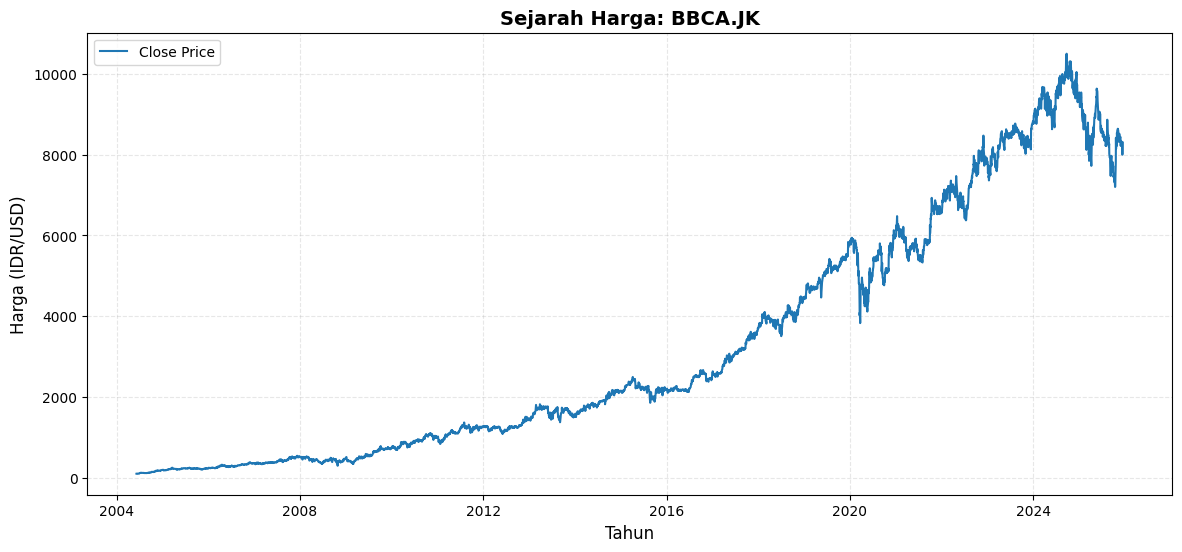

   📅 Periode: 2004-06-08 s/d 2025-12-15
   📉 Low: 99.04
   📈 High: 10,501.00
------------------------------------------------------------

🔄 Sedang memproses: BBRI.JK...


/tmp/ipython-input-227358026.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


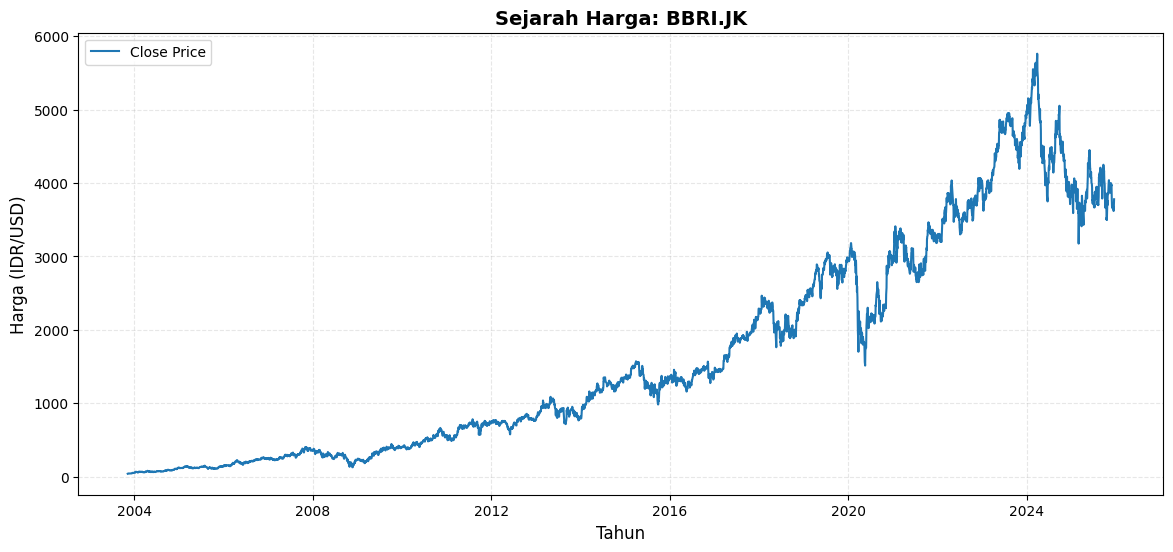

   📅 Periode: 2003-11-10 s/d 2025-12-15
   📉 Low: 40.00
   📈 High: 5,763.10
------------------------------------------------------------

🔄 Sedang memproses: NVDA...


/tmp/ipython-input-227358026.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


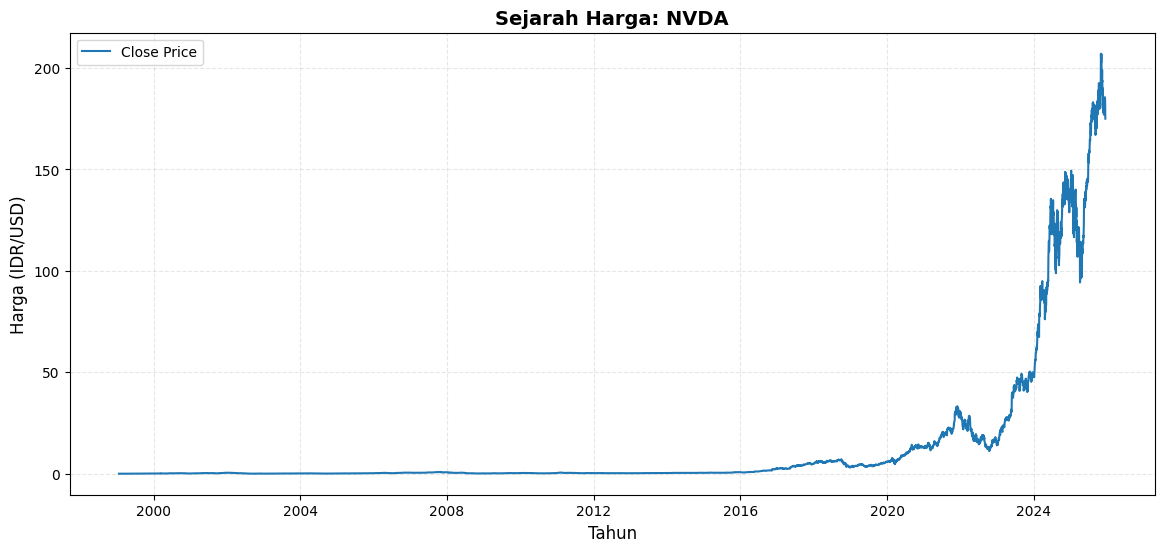

   📅 Periode: 1999-01-22 s/d 2025-12-12
   📉 Low: 0.03
   📈 High: 207.03
------------------------------------------------------------

🔄 Sedang memproses: AAPL...


/tmp/ipython-input-227358026.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


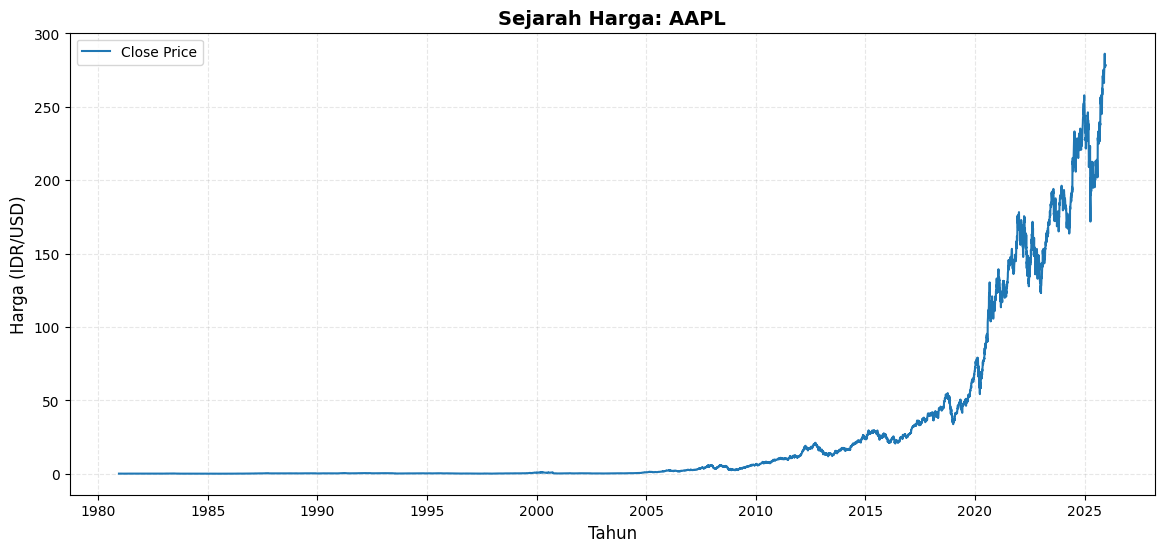

   📅 Periode: 1980-12-12 s/d 2025-12-12
   📉 Low: 0.04
   📈 High: 286.19
------------------------------------------------------------

🔄 Sedang memproses: BTC-USD...


/tmp/ipython-input-227358026.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


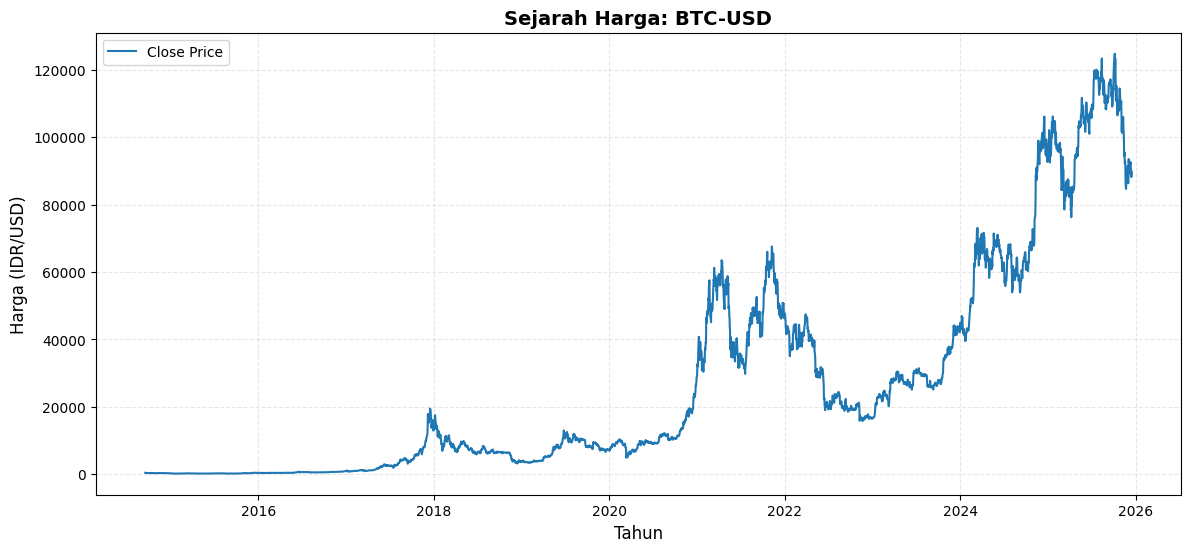

   📅 Periode: 2014-09-17 s/d 2025-12-15
   📉 Low: 178.10
   📈 High: 124,752.53
------------------------------------------------------------



In [ ]:
# === CELL 3: VISUALISASI DATA (EDA) - MODE TERPISAH ===
# Menampilkan grafik Full Size satu per satu biar detail kelihatan.

def visualize_data_history():
    print("📊 MEMULAI VISUALISASI DATA HISTORIS (MODE: MAX)...\n")

    # Loop untuk setiap aset
    for ticker in TICKERS:
        print(f"🔄 Sedang memproses: {ticker}...")

        # Download data max
        df = yf.download(ticker, period="max", progress=False)
        df = df.dropna()

        if df.empty:
            print(f"⚠️ Warning: Data {ticker} kosong! Skip.\n")
            continue

        # [PENTING] Bikin Canvas Baru untuk SETIAP ticker
        # Jadi gambarnya gak nyatu, tapi terpisah satu-satu
        plt.figure(figsize=(14, 6))

        plt.plot(df.index, df['Close'], label='Close Price', color='#1f77b4', linewidth=1.5)

        # Dekorasi Grafik
        plt.title(f"Sejarah Harga: {ticker}", fontsize=14, fontweight='bold')
        plt.xlabel('Tahun', fontsize=12)
        plt.ylabel('Harga (IDR/USD)', fontsize=12)
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3, linestyle='--')

        # Render gambar SAAT INI JUGA (Biar terpisah)
        plt.show()

        # Statistik di bawah gambar
        print(f"   📅 Periode: {df.index[0].date()} s/d {df.index[-1].date()}")
        print(f"   📉 Low: {df['Close'].min().item():,.2f}")
        print(f"   📈 High: {df['Close'].max().item():,.2f}")
        print("-" * 60 + "\n")

# Jalankan fungsinya
visualize_data_history()

In [ ]:
# === CELL 4: TRAINING LOOP & EVALUATION (THE GYM) ===

# 1. Definisikan Arsitektur Model (Resep Kue Lapis)
def create_model(input_shape):
    model = Sequential()

    # Layer 1: LSTM (Analis Junior) - Return Sequences = True (Oper ke atasan)
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2)) # Istirahat 20%

    # Layer 2: LSTM (Analis Senior) - Return Sequences = False (Rangkum hasil)
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))

    # Layer 3: Dense (Tim Perumus)
    model.add(Dense(units=25))

    # Layer 4: Output (Harga Prediksi)
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 2. Eksekusi Training
metrics_record = [] # Buku rapor

print("🏋️ MULAI SESI LATIHAN (TRAINING)... Siapkan kopi!\n")

for ticker in TICKERS:
    print(f"{'='*50}")
    print(f"🚀 PROSES: {ticker}")
    print(f"{'='*50}")

    # A. Ambil Data (Pake fungsi dari Cell 2)
    # Variabel x_test dan real_y_test penting buat ujian nanti
    x_train, y_train, x_test, real_y_test, scaler, df_raw = prepare_data(ticker, LOOKBACK)

    if x_train is None:
        print(f"❌ Skip {ticker} karena data bermasalah.")
        continue

    # B. Bangun Model
    model = create_model((x_train.shape[1], 1))

    # C. Training (Belajar)
    # EarlyStopping: Stop kalau 3 ronde gak tambah pinter (hemat waktu)
    early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

    print(f"🧠 Sedang melatih otak {ticker}...")
    history = model.fit(x_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[early_stop],
                        verbose=1) # verbose=1 biar keliatan progress bar jalan

    # D. Evaluasi (Ujian Dadakan)
    print(f"\n🧐 UJIAN: Mengukur kepintaran model pada data test...")
    predictions = model.predict(x_test, verbose=0)

    # Balikin angka 0-1 jadi Rupiah/Dollar asli
    predictions = scaler.inverse_transform(predictions)

    # Hitung Error
    mse = mean_squared_error(real_y_test, predictions)
    rmse = np.sqrt(mse) # Error dalam mata uang asli
    mae = mean_absolute_error(real_y_test, predictions) # Rata-rata meleset
    mape = np.mean(np.abs((real_y_test - predictions) / real_y_test)) * 100 # Error persen

    print(f"📊 RAPOR AKHIR {ticker}:")
    print(f"   -> RMSE (Root Mean Squared Error): {rmse:,.2f}")
    print(f"   -> MAE  (Rata-rata Meleset)      : {mae:,.2f}")
    print(f"   -> MAPE (Persentase Error)       : {mape:.2f}%")

    # Catat rapor
    metrics_record.append({
        'Ticker': ticker,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })

    # E. Simpan Hasil
    safe_ticker = ticker.replace('.', '_').replace('-', '_') # BBCA.JK -> BBCA_JK
    model_save_path = os.path.join(MODEL_DIR, f"{safe_ticker}_model.h5")
    scaler_save_path = os.path.join(MODEL_DIR, f"{safe_ticker}_scaler.pkl")

    model.save(model_save_path)
    joblib.dump(scaler, scaler_save_path)
    print(f"💾 Disimpan: {safe_ticker}_model.h5 & {safe_ticker}_scaler.pkl")

print("\n🎉 SEMUA ASET SELESAI DILATIH!")

🏋️ MULAI SESI LATIHAN (TRAINING)... Siapkan kopi!

🚀 PROSES: BBCA.JK

📥 Sedang download data MAXIMUM untuk: BBCA.JK...


/tmp/ipython-input-2045191313.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


   📊 Total Data Ditemukan: 5313 hari perdagangan.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🧠 Sedang melatih otak BBCA.JK...
Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0075
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0334e-04
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4172e-04
Epoch 4/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2482e-04
Epoch 5/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.9318e-04
Epoch 6/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2853e-04
Epoch 7/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0464e-04
Epoch 8/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.0473e-04
Epoch 9/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8195e-04
Epoch 9: early stopping

🧐 UJIAN: Mengukur kepintaran model pada data test...


📊 RAPOR AKHIR BBCA.JK:
   -> RMSE (Root Mean Squared Error): 350.71
   -> MAE  (Rata-rata Meleset)      : 289.58
   -> MAPE (Persentase Error)       : 3.44%
💾 Disimpan: BBCA_JK_model.h5 & BBCA_JK_scaler.pkl
🚀 PROSES: BBRI.JK

📥 Sedang download data MAXIMUM untuk: BBRI.JK...


/tmp/ipython-input-2045191313.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


   📊 Total Data Ditemukan: 5464 hari perdagangan.
🧠 Sedang melatih otak BBRI.JK...
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0050
Epoch 2/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0645e-04
Epoch 3/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.2781e-04
Epoch 4/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1379e-04
Epoch 5/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0097e-04
Epoch 6/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9297e-04
Epoch 7/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8734e-04
Epoch 8/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8075e-04
Epoch 9/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6309e-04
Epoch 10/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5664e-04
Epoch 11/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7402e-04
Epoch 12/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5807e-04
Epoch 13/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7047e-04
Epoch 14/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5985e-04
Epoch 15/25
13

📊 RAPOR AKHIR BBRI.JK:
   -> RMSE (Root Mean Squared Error): 109.72
   -> MAE  (Rata-rata Meleset)      : 85.18
   -> MAPE (Persentase Error)       : 2.17%
💾 Disimpan: BBRI_JK_model.h5 & BBRI_JK_scaler.pkl
🚀 PROSES: NVDA

📥 Sedang download data MAXIMUM untuk: NVDA...


/tmp/ipython-input-2045191313.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


   📊 Total Data Ditemukan: 6766 hari perdagangan.
🧠 Sedang melatih otak NVDA...
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.5404e-05
Epoch 2/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1198e-06
Epoch 3/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5403e-06
Epoch 4/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8303e-06
Epoch 5/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.0706e-06
Epoch 6/25
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5600e-06
Epoch 6: early stopping

🧐 UJIAN: Mengukur kepintaran model pada data test...


📊 RAPOR AKHIR NVDA:
   -> RMSE (Root Mean Squared Error): 10.00
   -> MAE  (Rata-rata Meleset)      : 6.28
   -> MAPE (Persentase Error)       : 8.30%
💾 Disimpan: NVDA_model.h5 & NVDA_scaler.pkl
🚀 PROSES: AAPL

📥 Sedang download data MAXIMUM untuk: AAPL...


/tmp/ipython-input-2045191313.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


   📊 Total Data Ditemukan: 11343 hari perdagangan.
🧠 Sedang melatih otak AAPL...
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 5.8585e-05
Epoch 2/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.8379e-06
Epoch 3/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.9349e-06
Epoch 4/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 8.9527e-06
Epoch 5/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.1566e-06
Epoch 6/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.6570e-06
Epoch 7/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.6895e-06
Epoch 7: early stopping

🧐 UJIAN: Mengukur kepintaran model pada data test...


📊 RAPOR AKHIR AAPL:
   -> RMSE (Root Mean Squared Error): 5.11
   -> MAE  (Rata-rata Meleset)      : 3.67
   -> MAPE (Persentase Error)       : 3.42%
💾 Disimpan: AAPL_model.h5 & AAPL_scaler.pkl
🚀 PROSES: BTC-USD

📥 Sedang download data MAXIMUM untuk: BTC-USD...


/tmp/ipython-input-2045191313.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


   📊 Total Data Ditemukan: 4108 hari perdagangan.
🧠 Sedang melatih otak BTC-USD...
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0037
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5014e-04
Epoch 3/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3044e-04
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2581e-04
Epoch 5/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4475e-04
Epoch 6/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7038e-04
Epoch 7/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5309e-04
Epoch 8/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7027e-04
Epoch 9/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9181e-04
Epoch 10/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5123e-04
Epoch 11/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7363e-04
Epoch 12/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3024e-04
Epoch 13/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.3342e-04
Epoch 14/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5983e-04
Epoch 15/25
1

📊 RAPOR AKHIR BTC-USD:
   -> RMSE (Root Mean Squared Error): 6,389.55
   -> MAE  (Rata-rata Meleset)      : 5,423.05
   -> MAPE (Persentase Error)       : 6.60%
💾 Disimpan: BTC_USD_model.h5 & BTC_USD_scaler.pkl

🎉 SEMUA ASET SELESAI DILATIH!


📈 MEMBUAT GRAFIK PREDIKSI (ACTUAL vs TRAINING vs TESTING)...

🔄 Sedang memproses grafik: BBCA.JK...


/tmp/ipython-input-2045191313.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)



📥 Sedang download data MAXIMUM untuk: BBCA.JK...
   📊 Total Data Ditemukan: 5313 hari perdagangan.


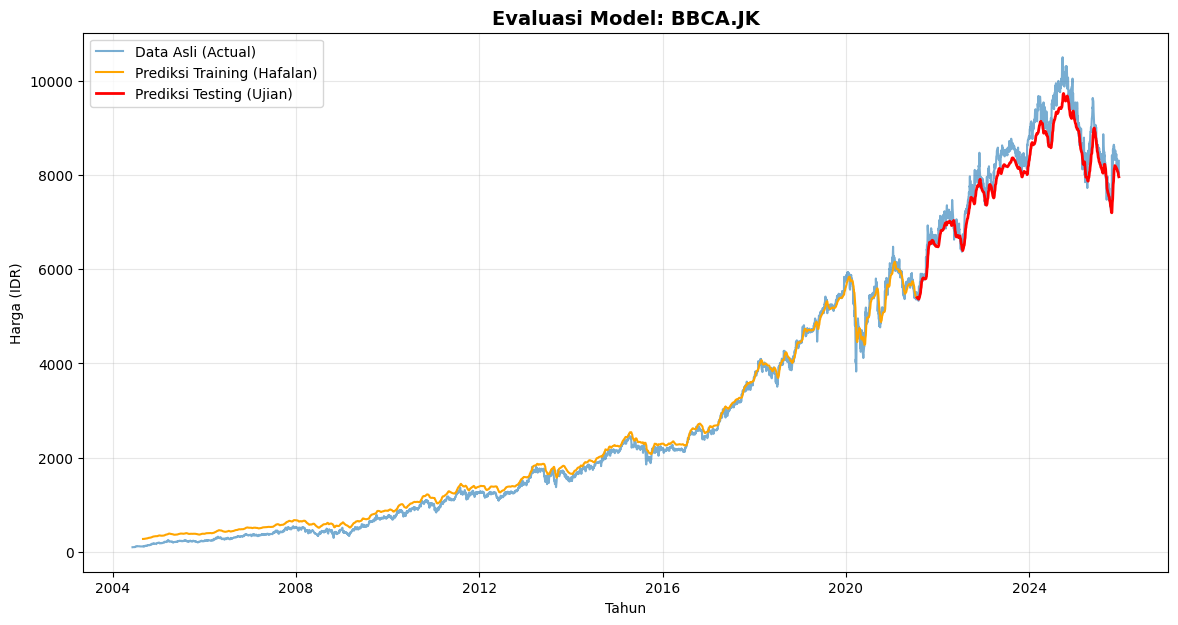

------------------------------------------------------------

🔄 Sedang memproses grafik: BBRI.JK...

📥 Sedang download data MAXIMUM untuk: BBRI.JK...


/tmp/ipython-input-2045191313.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


   📊 Total Data Ditemukan: 5464 hari perdagangan.


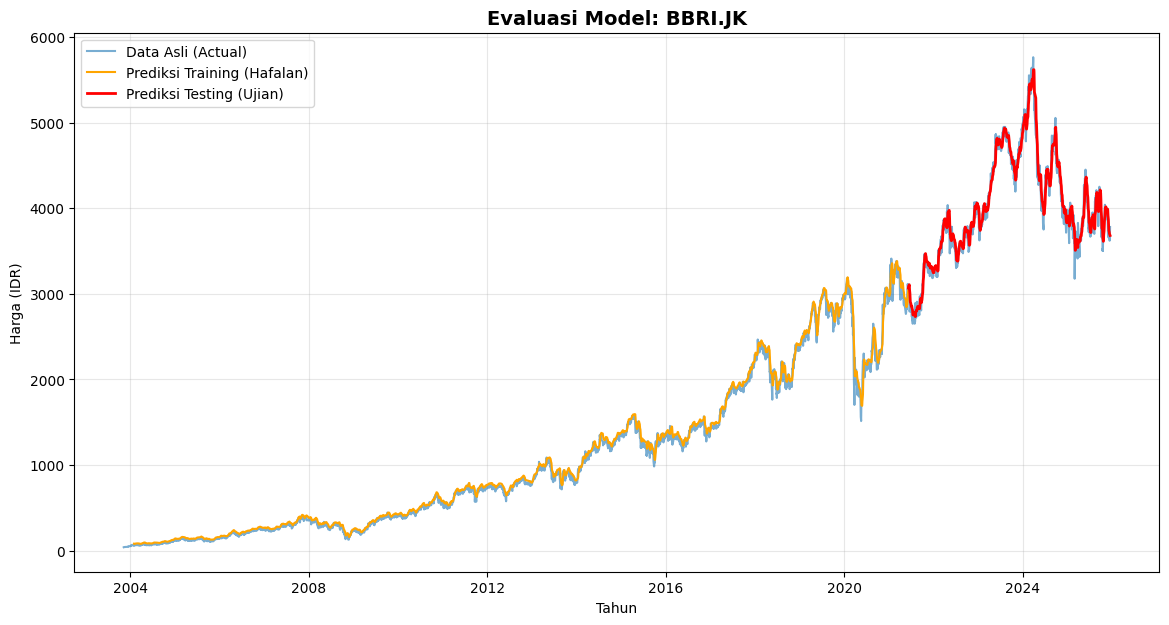

------------------------------------------------------------

🔄 Sedang memproses grafik: NVDA...

📥 Sedang download data MAXIMUM untuk: NVDA...


/tmp/ipython-input-2045191313.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


   📊 Total Data Ditemukan: 6766 hari perdagangan.


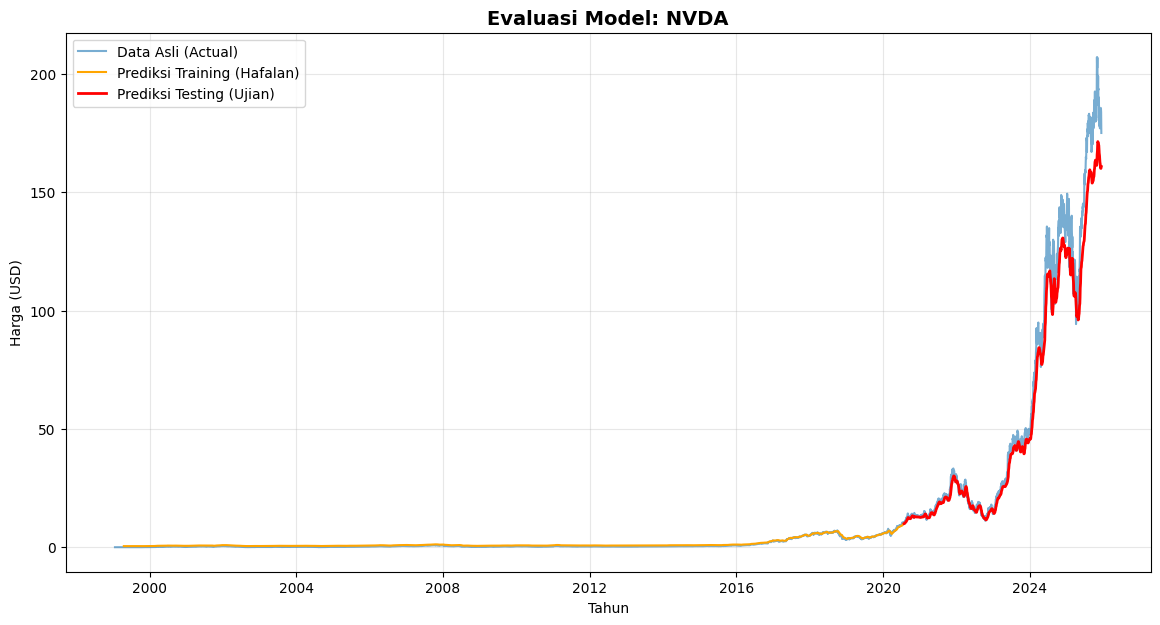

------------------------------------------------------------

🔄 Sedang memproses grafik: AAPL...

📥 Sedang download data MAXIMUM untuk: AAPL...


/tmp/ipython-input-2045191313.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


   📊 Total Data Ditemukan: 11343 hari perdagangan.


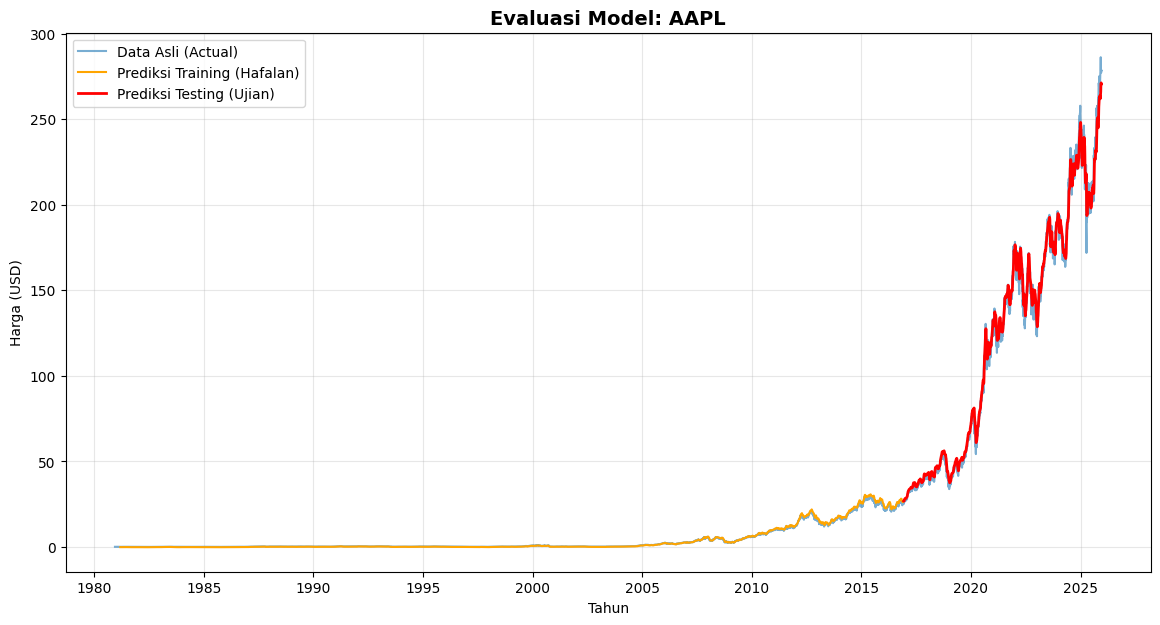

------------------------------------------------------------

🔄 Sedang memproses grafik: BTC-USD...

📥 Sedang download data MAXIMUM untuk: BTC-USD...


/tmp/ipython-input-2045191313.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="max", progress=False)


   📊 Total Data Ditemukan: 4108 hari perdagangan.


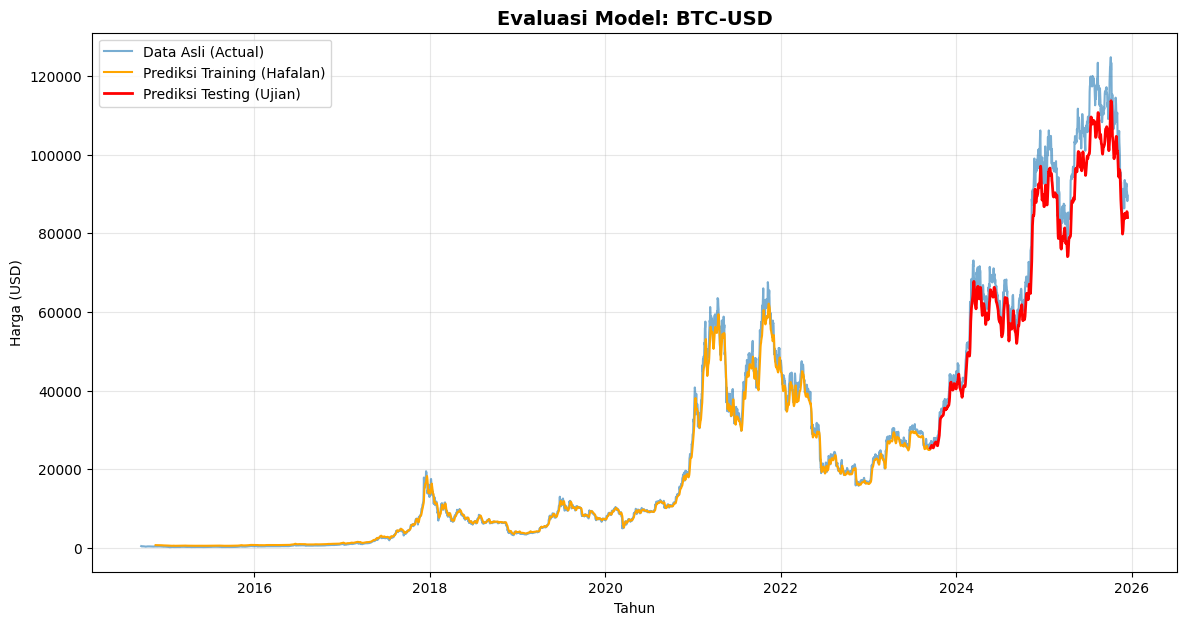

------------------------------------------------------------



In [ ]:
# === CELL 5: VISUALISASI PREDIKSI (TRAIN vs TEST) ===
from tensorflow.keras.models import load_model

def plot_predictions():
    print("📈 MEMBUAT GRAFIK PREDIKSI (ACTUAL vs TRAINING vs TESTING)...\n")

    for ticker in TICKERS:
        print(f"🔄 Sedang memproses grafik: {ticker}...")

        # 1. Load Model & Scaler yang sudah dilatih
        safe_ticker = ticker.replace('.', '_').replace('-', '_')
        model_path = os.path.join(MODEL_DIR, f"{safe_ticker}_model.h5")
        scaler_path = os.path.join(MODEL_DIR, f"{safe_ticker}_scaler.pkl")

        if not os.path.exists(model_path):
            print(f"⚠️ Model {ticker} tidak ditemukan. Skip.")
            continue

        loaded_model = load_model(model_path)
        loaded_scaler = joblib.load(scaler_path)

        # 2. Siapkan Data Ulang (Pake fungsi dari Cell 2)
        # Kita butuh x_train dan x_test buat disuruh nebak ulang
        x_train, y_train, x_test, real_y_test, _, df_raw = prepare_data(ticker, LOOKBACK)

        if x_train is None: continue

        # 3. Lakukan Prediksi
        # Prediksi Data Latihan (Orange)
        train_predict = loaded_model.predict(x_train, verbose=0)
        train_predict = loaded_scaler.inverse_transform(train_predict)

        # Prediksi Data Ujian/Test (Merah)
        test_predict = loaded_model.predict(x_test, verbose=0)
        test_predict = loaded_scaler.inverse_transform(test_predict)

        # 4. Atur Posisi Grafik (Shift Logic)
        # Karena output prediksi bentuknya array pendek, kita harus pasin posisinya di sumbu waktu

        # Bikin array kosong seukuran data asli, isi NaN (biar gak ada garis nyambung aneh)
        full_data_len = len(df_raw)

        # A. Array Plot Training
        train_plot = np.empty((full_data_len, 1))
        train_plot[:, :] = np.nan
        # Isi dari index [lookback] sampai [lookback + len(train_predict)]
        train_plot[LOOKBACK : LOOKBACK + len(train_predict), :] = train_predict

        # B. Array Plot Testing
        test_plot = np.empty((full_data_len, 1))
        test_plot[:, :] = np.nan
        # Isi mulai dari titik potong training split
        # Logikanya: Start Test = (Total Data * 0.8)
        train_size = int(len(df_raw) * TRAIN_SPLIT)
        test_start_idx = train_size

        # Pastikan panjangnya pas (handling potential index mismatch)
        end_idx = test_start_idx + len(test_predict)
        if end_idx <= full_data_len:
             test_plot[test_start_idx : end_idx, :] = test_predict
        else:
             # Fallback kalau index meleset dikit (kadang terjadi di time series)
             test_plot[test_start_idx : full_data_len, :] = test_predict[:full_data_len-test_start_idx]

        # 5. GAMBAR GRAFIK (1 Ticker 1 Gambar)
        plt.figure(figsize=(14, 7))

        # Garis 1: Data Asli (Biru)
        plt.plot(df_raw.index, df_raw['Close'], label='Data Asli (Actual)', color='#1f77b4', alpha=0.6)

        # Garis 2: Prediksi Training (Orange)
        plt.plot(df_raw.index, train_plot, label='Prediksi Training (Hafalan)', color='orange', linewidth=1.5)

        # Garis 3: Prediksi Testing (Merah) - INI YANG PENTING
        plt.plot(df_raw.index, test_plot, label='Prediksi Testing (Ujian)', color='red', linewidth=2)

        plt.title(f"Evaluasi Model: {ticker}", fontsize=14, fontweight='bold')
        plt.xlabel('Tahun')
        plt.ylabel(f"Harga ({'IDR' if 'JK' in ticker else 'USD'})")
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.show()

        print("-" * 60 + "\n")

# Jalankan
plot_predictions()

In [ ]:
# === CELL 6: KLASEMEN AKHIR & DOWNLOAD (WISUDA) ===
# Menampilkan siapa juara akurasi dan download file otak modelnya.

import pandas as pd
from google.colab import files

print("🏆 KLASEMEN AKURASI MODEL (URUTAN DARI YANG TERPINTAR) 🏆")
print("=" * 70)

# 1. Tampilkan Klasemen (Leaderboard)
# Kita cek apakah variabel 'metrics_record' dari Cell 4 masih ada di memori
if 'metrics_record' in locals() and metrics_record:
    # Bikin DataFrame biar tabelnya rapi
    df_results = pd.DataFrame(metrics_record)

    # Format angka biar gak kebanyakan koma
    pd.options.display.float_format = '{:,.2f}'.format

    # Urutkan berdasarkan MAPE terkecil (Makin kecil makin akurat)
    df_results = df_results.sort_values(by='MAPE', ascending=True)

    # Reset index biar nomor urutnya bener (1, 2, 3...)
    df_results = df_results.reset_index(drop=True)
    df_results.index += 1

    print(df_results[['Ticker', 'MAPE', 'RMSE', 'MAE']])
    print("-" * 70)
    print("ℹ️ PANDUAN BACA:")
    print("   -> Juara 1 (Paling Atas) = Paling gampang ditebak.")
    print("   -> Posisi Bawah = Paling liar/susah ditebak.")
    print("   -> MAPE < 5% = Bagus Banget | > 10% = Hati-hati.")
else:
    print("⚠️ Data rapor kosong. Pastikan Cell 4 sudah dijalankan sampai selesai.")

# 2. Packing & Download
print("\n📦 SEDANG MEMBUNGKUS FILE MODEL (ZIP)...")

# Pakai command zip bawaan Linux di Colab
# -r artinya recursive (masukin semua isi folder), -q artinya quiet (gak usah berisik nge-print nama file)
!zip -r models_lstm_ready.zip models

print(f"\n✅ SIAP! File 'models_lstm_ready.zip' akan didownload otomatis.")
print("   (Simpan file ini baik-baik di laptop, kita butuh buat Dashboard nanti).")

# Trigger download browser
try:
    files.download('models_lstm_ready.zip')
except Exception as e:
    print(f"❌ Auto-download gagal: {e}")
    print("👉 Silakan download manual di icon Folder (sebelah kiri) -> Klik kanan 'models_lstm_ready.zip' -> Download.")

🏆 KLASEMEN AKURASI MODEL (URUTAN DARI YANG TERPINTAR) 🏆
    Ticker  MAPE     RMSE      MAE
1  BBRI.JK  2.17   109.72    85.18
2     AAPL  3.42     5.11     3.67
3  BBCA.JK  3.44   350.71   289.58
4  BTC-USD  6.60 6,389.55 5,423.05
5     NVDA  8.30    10.00     6.28
----------------------------------------------------------------------
ℹ️ PANDUAN BACA:
   -> Juara 1 (Paling Atas) = Paling gampang ditebak.
   -> Posisi Bawah = Paling liar/susah ditebak.
   -> MAPE < 5% = Bagus Banget | > 10% = Hati-hati.

📦 SEDANG MEMBUNGKUS FILE MODEL (ZIP)...
  adding: models/ (stored 0%)
  adding: models/BBCA_JK_model.h5 (deflated 14%)
  adding: models/NVDA_scaler.pkl (deflated 38%)
  adding: models/BBRI_JK_model.h5 (deflated 14%)
  adding: models/BBRI_JK_scaler.pkl (deflated 40%)
  adding: models/AAPL_model.h5 (deflated 14%)
  adding: models/BTC_USD_scaler.pkl (deflated 39%)
  adding: models/BBCA_JK_scaler.pkl (deflated 39%)
  adding: models/NVDA_model.h5 (deflated 14%)
  adding: models/BTC_USD_model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>